In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [44]:
df = pd.read_csv("Gemini_BTCUSD_1h.csv", parse_dates=["date"])

In [45]:
def generate_label_window(closings, dim: int, lookahead: int):
    window = closings[:dim]
    window_last_price = window[-1]
    with_lookahead = closings[:dim + lookahead]

    stddev_half = torch.std(with_lookahead) * 0.5

    buy = torch.abs(torch.min(with_lookahead) - window_last_price) < stddev_half 
    sell = torch.abs(torch.max(with_lookahead) - window_last_price) < stddev_half

    if buy == sell:
        return 0
    
    return -1 if sell else 1

In [46]:
closings = torch.flip(torch.tensor(df["close"][:4000], dtype=torch.float), dims=(0,))
dim = 60
lookahead = 24
win_size = dim + lookahead

n = len(closings) - dim - lookahead

xTr_sell = []
yTr_sell = []

xTr_buy = []
yTr_buy = []

xTr_none = []

for win_start in range(n):
  xTr_i = closings[win_start:][:dim].clone()
  yTr_i = generate_label_window(closings[win_start:], dim, lookahead)

  xTr_i -= torch.mean(xTr_i)
  xTr_i /= torch.std(xTr_i)
  
  if yTr_i == 1:
    xTr_buy.append(xTr_i)
    yTr_buy.append(1)
  elif yTr_i == -1:
    xTr_sell.append(xTr_i)
    yTr_sell.append(1)
  else:
    xTr_none.append(xTr_i)


xTr_sell = torch.stack(xTr_sell + xTr_none[:len(xTr_sell)])
xTr_buy = torch.stack(xTr_buy + xTr_none[:len(xTr_buy)])

yTr_sell = torch.stack([torch.tensor(yTr_sell + [0] * len(yTr_sell), dtype=torch.float)]).mT
yTr_buy = torch.stack([torch.tensor(yTr_buy + [0] * len(yTr_buy), dtype=torch.float)]).mT

In [47]:
import torch


def train_model(xTr, yTr):
    model = torch.nn.Sequential( 
        torch.nn.Linear(in_features = dim, out_features = 10),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features = 10, out_features = 10),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features = 10, out_features = 1),
        torch.nn.Sigmoid(),
    )

    # Train the model 
    criterion = torch.nn.BCELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    
    err = 0
    num_epochs = 10000
    for epoch in range(num_epochs): 
        # Forward pass 
        y_pred = model(xTr)
        loss = criterion(y_pred, yTr) 
    
        # Backward pass and optimization 
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
    
        err = torch.abs(y_pred - yTr).sum() / yTr.shape[0]

        # Print the loss every 100 epochs 
        if (epoch+1) % 100 == 0: 
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return model, err


sell_model, sell_error = train_model(xTr_sell, yTr_sell)
buy_model, buy_error = train_model(xTr_buy, yTr_buy)

print(f"Buy Test Error: {buy_error * 100}%, Sell Test Error: {sell_error * 100}%")

Epoch [100/10000], Loss: 0.4050
Epoch [200/10000], Loss: 0.2926
Epoch [300/10000], Loss: 0.2206
Epoch [400/10000], Loss: 0.1658
Epoch [500/10000], Loss: 0.1157
Epoch [600/10000], Loss: 0.0770
Epoch [700/10000], Loss: 0.0489
Epoch [800/10000], Loss: 0.0302
Epoch [900/10000], Loss: 0.0202
Epoch [1000/10000], Loss: 0.0146
Epoch [1100/10000], Loss: 0.0111
Epoch [1200/10000], Loss: 0.0087
Epoch [1300/10000], Loss: 0.0071
Epoch [1400/10000], Loss: 0.0060
Epoch [1500/10000], Loss: 0.0051
Epoch [1600/10000], Loss: 0.0045
Epoch [1700/10000], Loss: 0.0039
Epoch [1800/10000], Loss: 0.0035
Epoch [1900/10000], Loss: 0.0031
Epoch [2000/10000], Loss: 0.0028
Epoch [2100/10000], Loss: 0.0025
Epoch [2200/10000], Loss: 0.0023
Epoch [2300/10000], Loss: 0.0021
Epoch [2400/10000], Loss: 0.0019
Epoch [2500/10000], Loss: 0.0018
Epoch [2600/10000], Loss: 0.0016
Epoch [2700/10000], Loss: 0.0015
Epoch [2800/10000], Loss: 0.0014
Epoch [2900/10000], Loss: 0.0013
Epoch [3000/10000], Loss: 0.0013
Epoch [3100/10000],

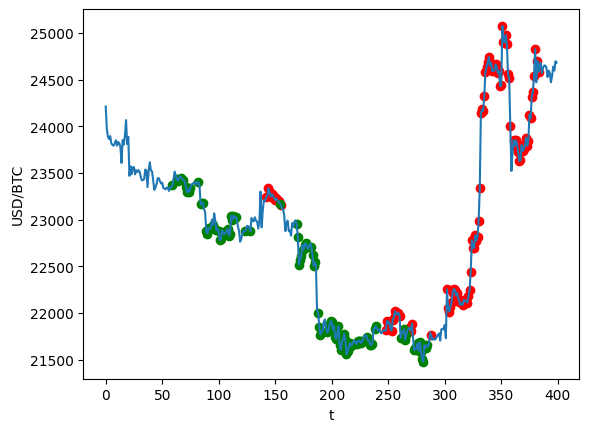

In [51]:
closings_te = torch.flip(torch.tensor(df["close"][:6000], dtype=torch.float)[5600:], dims=(0,))

sells_x, sells_y, buys_x, buys_y = [], [], [], []

for win_s in range(len(closings_te) - dim):
    window = closings_te[win_s:][:dim].clone()
    window -= torch.mean(window)
    window /= torch.std(window)

    buys = buy_model(window)
    sells = sell_model(window)

    x = win_s + dim - 1
    y = closings_te[x]
    if buys > 0.5 or sells > 0.5:
        if buys > sells:
            buys_x.append(x)
            buys_y.append(y)
        elif sells:
            sells_x.append(x)
            sells_y.append(y)

while len(buys_x) > len(sells_x):
    buys_x.pop()
    buys_y.pop()

#fee_keep = (1 - 0.2/100) ** (2 * len(sells_y))
#profit = torch.sum(torch.tensor(sells_y) / torch.tensor(buys_y) - 1) * 100 * fee_keep

#print(f"Profit: {profit}%, Fee keep: {fee_keep * 100}%")

plt.scatter(sells_x, sells_y, c="red")
plt.scatter(buys_x, buys_y, c="green")
plt.plot(closings_te)
plt.ylabel("USD/BTC")
plt.xlabel("t")
plt.show()